<a href="https://colab.research.google.com/github/deeplearner2019/ULMFiT/blob/master/twitter_ulmfit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ** Twitter US Airline Sentiment Analysis Using ULMFiT**
###### *by Arun Raja*
---




### *Section 1. Introduction to Transfer Learning and ULMFiT*

> Transfer learning has created significant impact on Computer Vision but not so on Natural Language Processing. First of all, transfer learning models require large amounts of data and takes days to converge. For instance, Dai and Le (2015) fine-tuned the language model but required millions of documents of the specific domain to achieve good performance, which is not desirable for practical purposes. The problem is not with the language modelling fine-tuning but how to train them effectively such that a small amount of data is required to achieve the same performance as with large data corpora. On the other hand, training on a small dataset can cause the language model to overfit severely. Thus, a fine-tuning method is required to effectively train using a small amount of data and yet prevent severe overfitting. Therefore, Howard and Ruder (2018) came up with: Universal Language Model Fine-tuning (ULMFiT)

###*Section 2. The Process of ULMFiT*

> ULMFiT consists of the following 3 stages:
> 1. LM pre-training: The language model (LM) is trained on general-domain corpus to capture general features of languages in its layers. For instance, Wikitext-103 corpus was used by Howard and Ruder (2018) to pretrain the LM for English.
> 2. LM finetuning: The entire LM is fine tuned on the target data using discriminative fine tuning and slanted triangular learning rates to learn task specific classifer tuning.
>     * Discriminative finetuning: The different layers of the LM capture different types of information , thus they should be finetuned to different extents. In order to allow each layer to capture information to different extents, we manipulate the learning rates of different layers via discriminative finetuning. 
>     In the case of stochastic gradient descent, where we decide on one learning rate for all layers, the model's parameters θ at time step t updates as follows:
> ![sgd_formula](https://i.paste.pics/77J2C.png) 
> 
>     In the case of discriminative finetuning, we would need to adjust the parameters at each layer of the neural network. thus we consider θ= {θ_1,...θ_l} where θ_l refers to the parameter of the l=th layer. In the same way, we have a learning rate corresponding to each of the L layers: {η_1, . . . , η_l} where η_l is the learning rate of the l-th layer. Thus the stochastic gradient update in the context of discriminative finetuning is:
> ![](https://i.paste.pics/77J31.png)

> Through experimentation, Howard and Ruder found that discriminative finetuning works well when the learning rate of the final layer ,L, was chosen first and the learning rate of the other layers were updated as follows: **η_l−1 =η_l/2.6 **
>     * Slanted triangular learning rates (SLTR) : To allow the LM to adapt its parameters to task-specific features, it is important to quickly converge. Thus, SLTR is used as it first linearly increases and then decreases linearly as shown below:
> ![](https://i.paste.pics/77J55.png)    
> 
> 3. Finally, Classifier finetuning: finetuned language model is used on target task with gradual defreezing and STLR to preserve low-level representations and adjust high-level representations
>     *     Gradual unfreezing: Instead of finetuning all layers at once, the last layer is 'unfreezed' and finetuned first as  it is considered to have the least general knowledge (Yosinski et al., 2014). How the gradual unfreezing proceeds is as follows:

>             a) the last layer is unfrozen and finetuned for one epoch

>             b)the second last layer is unfrozen and both (last and second last layers) are finetuned for one epoch

>             c)Once all the layers have been unfrozen, the entire network is finetuned till convergence is achieved.
>         
> To wrap-up this explanation on the ULMFiT process, the newly proposed techniques of discriminative finetuning, slanted triangular learning rates and gradual unfreezing work in synergy to enable ULMFiT to perform well on different datasets.
> 

    


### *Section 3. Task and EDA*

> Our aim is to classify tweets about the major American airlines into 3 classes, namely, neutral, negative and positive, using ULMFiT.
> The dataset contains 14427 labelled tweets.
> We will be carrying out an exploratory data analysis or EDA on the dataset to understand more about the different tweets about the airlines-

In [0]:
#importing the following libraries-
import numpy as np
import pandas as pd
import seaborn as sns
import re
from pathlib import Path
from sklearn.model_selection import train_test_split
from fastai.text import *
# we will be using the fast.ai library to build the ULMFiT model as there are specific methods in the fast.ai library for the different techniques involved in ULMFiT

In [0]:
#loading data from GDrive
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#loading data from folder

data_path=Path('/content/gdrive/My Drive/fellowship.ai')
input_name='Tweets.csv'
input_path=data_path/input_name
df_input=pd.read_csv(input_path)
print("The shape of the input csv file containing all tweets is",df_input.shape)


The shape of the input csv file containing all tweets is (14640, 15)


In [0]:
# some example of entries in the input data table
df_input.sample(10,random_state=0)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
13983,5.696820e+17,negative,0.6163,Late Flight,0.6163,American,NaN,zsalim03,NaN,0,@AmericanAir In car gng to DFW. Pulled over 1h...,NaN,2/22/2015 18:15,Texas,Central Time (US & Canada)
14484,5.696080e+17,negative,0.7039,Bad Flight,0.3587,American,NaN,sa_craig,NaN,0,"@AmericanAir after all, the plane didn’t land ...",NaN,2/22/2015 13:22,"College Station, TX",Central Time (US & Canada)
6403,5.678790e+17,negative,1.0000,Cancelled Flight,1.0000,Southwest,NaN,DanaChristos,NaN,1,@SouthwestAir can't believe how many paying cu...,NaN,2/17/2015 18:52,CT,Eastern Time (US & Canada)
9653,5.697580e+17,negative,1.0000,Can't Tell,1.0000,US Airways,NaN,rossj987,NaN,0,@USAirways I can legitimately say that I would...,NaN,2/22/2015 23:16,"Washington, D.C.",Eastern Time (US & Canada)
13268,5.699010e+17,negative,1.0000,Customer Service Issue,1.0000,American,NaN,tranpham18,NaN,0,@AmericanAir still no response from AA. great ...,NaN,2/23/2015 8:44,New York City,Eastern Time (US & Canada)
2384,5.692350e+17,neutral,1.0000,NaN,NaN,United,NaN,setfive,NaN,0,@united we have developers flying down tmrw mo...,NaN,2/21/2015 12:39,"Central Sq. Cambridge, MA",Eastern Time (US & Canada)
9613,5.698240e+17,negative,0.6699,Customer Service Issue,0.3411,US Airways,NaN,earthXplorer,NaN,1,@USAirways hello??? Anyone there?,NaN,2/23/2015 3:41,"Miami, Fl. USA",Eastern Time (US & Canada)
11612,5.678800e+17,negative,0.7072,Late Flight,0.7072,US Airways,NaN,AliNHamdani,NaN,0,@USAirways @husainhaqqani Mr. Husain u shld pr...,NaN,2/17/2015 18:56,Islamabad,Islamabad
9252,5.700220e+17,negative,1.0000,Late Flight,1.0000,US Airways,NaN,BradleyPollock,NaN,0,"@USAirways not likely, flightaware says plane ...",NaN,2/23/2015 16:46,NaN,NaN
13923,5.696910e+17,negative,1.0000,Customer Service Issue,1.0000,American,NaN,kaps12,NaN,0,@AmericanAir they don't even give an option to...,NaN,2/22/2015 18:50,NaN,NaN


In [0]:
# we only require rge airline_sentiment and text row for our input and targetted output, thus we select just those columns
df_input_crop=df_input[['airline_sentiment','text']]
df_input_crop.sample(10)

,airline_sentiment,text
4794,positive,@SouthwestAir you're my early frontrunner for ...
10480,negative,@USAirways how is it that my flt to EWR was Ca...
8067,negative,@JetBlue what is going on with your BDL to DCA...
8880,neutral,@JetBlue do they have to depart from Washingto...
8292,negative,@JetBlue I can probably find some of them. Are...
927,negative,@united still waiting to hear back. My wallet ...
3165,negative,@united Yes my flight was rebooked. I'm just l...
7894,neutral,@JetBlue Thank you ! What about Paris ? Could ...
2818,negative,"@united not 100% sure, however my ticket inclu..."
9145,positive,@usairways great crew for flight 504 PHX to YV...


In [0]:
#before, we start dividing the dataset into train/test/validation sets, we need to know whether the data is class imbalanced
#class imbalance can occur based on the sentiment class or airline class-

print('The distribution of data according to the different sentiment classes is:\n',df_input_crop['airline_sentiment'].value_counts())


The distribution of data according to the different sentiment classes is:
 negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64


In [0]:
print('The distribution of data according to the different sentiment classes is:\n',df_input['airline'].value_counts())


The distribution of data according to the different sentiment classes is:
 United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64


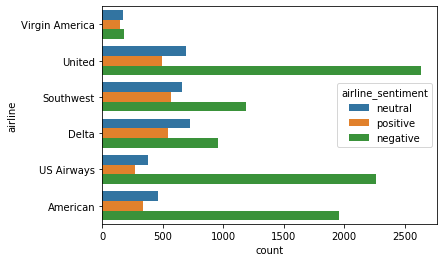

In [0]:
# to visualise the class imbalance due to both sentiment and airline class, we will use bar chart-
sns.countplot(y='airline', hue='airline_sentiment', data=df_input)

##### Section 3.1. The Problem of Class Imbalance

> From our EDA, we have discovered that there is a class imbalance with respect to the different airlines. Thus, there is a possibility that the model associates a certain sentiment with a certain airline. However, that is not our aim. Our aim is for the model to associate and map a certain tweet to a certain sentiment. Therefore, I felt that all airline names which appear after the '@' symbol should be replaced with '@airline'. That way we get rid of the airline class imbalance issue. 

In [0]:




regex=r"@(VirginAmerica|united|SouthwestAir|Delta|USAirways|AmericanAir|JetBlue)"
def replace(text):
    return re.sub(regex, '@airline',text, flags=re.IGNORECASE)
df_input_crop['text']=df_input_crop['text'].apply(replace)
df_input_crop['text'].sample(10)

# now all the airlines names have been replaced with the word 'airline'





/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


13298    @airline I tried already and I am on the waiti...
10132    @airline @airline my friends are stranded at K...
1913     @airline. If you show available seats, you nee...
4725     @airline : thanks.are flights operating now or...
1388     @airline after 2 days - 1 flight Cancelled Fli...
4540     @airline if I am enrolled in the ATL companion...
3135     @airline WTF!?!? Delay after delay. 15 hours Y...
11246    @airline new problem...had wrong last name on ...
8184     @airline Great Thank you, lets hope so! Could ...
4783     @airline you got me home over an hour and a ha...
Name: text, dtype: object

### *Section 4. Setting up Data*

> Now we will be splitting the dataset into training(80%) and validation(20%) sets

In [0]:
train_data,valid_data=train_test_split(df_input_crop, test_size=0.2)

### *Section 5. ULMFiT model development*

#####Section 5.1. ULMFiT step 1: LM Pretraining

>In this language model pretraining step, we capture the general features of the language.
>First, we will be standardising the momentum and weight decay values for this entire model development process.

> moms=(0.8,0.7)

> wd=0.1

>Weight decay refers to the value by which the weights are multiplied by after each update. This prevents weights from growing too large.
>Simply put, momentum accumulates the gradient of the previous steps to determine the direction to go and allows us to quickly converge.


In [0]:
moms=(0.8,0.7)
wd=0.1

In [0]:
#fast.ai needs a path to work on
fastai_path=Path('./').resolve()
fastai_path

PosixPath('/content')

In [0]:
# Here TextLMDataBunch formats the input data such that data can be called immediately for use in model training
input_data=TextLMDataBunch.from_df(fastai_path, train_data,valid_data)
# input_data.save('input_data.pkl')

In [0]:
#learn_process is our model 
learn_process=language_model_learner(input_data, AWD_LSTM, drop_mult=0.3)
#learning process occurs using wikipedia data
learn_process.freeze()

##### Section 5.2. Finetuning LM

> In this stage,the entire LM is fine tuned on the target data using discriminative fine tuning and slanted triangular learning rates to learn task specific classifer tuning.
> We incorporate the use of 1cycle policy (Leslie Smith et. al.) to training our neural network quickly.
> When we plot the losses across a range of learning rates, we will be picking the learning rate slight before the learning rate with minimum loss such that the loss is still improving.
> Leslie Smith recommends that we change the learning curve such that it increases to the optimal learning rate (minimum loss) from a lower learning rate for half the iterations and gradual reduces back to the lower learning rate for the remaining half of the iterations.
> As suggested in the fast.ai docs, we can let our maximum learning rate be tenth of the optimal learning rate as shown in the plot below.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


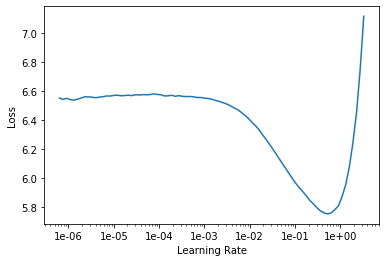

In [0]:
#lr_find helps to fine a good learning rate
learn_process.lr_find()
#plots the losses over a range of learning rates
learn_process.recorder.plot()

In [0]:
#from the plot above we can see that 5e-01 is the learning rate with minimum loss
# we will take our max learning rate in 1cyle to be tenth of that: 5e-02
learn_process.fit_one_cycle(1,5e-02,moms=moms,wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,4.344582,3.821296,0.295871,00:06


In [0]:
learn_process.unfreeze()

In [0]:
learn_process.save_encoder('encoder')

##### Section 5.3 Classifier finetuning

> The finetuned language model is used on target task with gradual defreezing and STLR to preserve low-level representations and adjust high-level representations.
> In this final stage, we further divide the dataset into training, validation and testing datasets
> The breakdown of the data is as follows:
> 
> * test data: 20%
> * training data: 64%
> * validation data: 16%

In [0]:
trainNvalid, test=train_test_split(df_input_crop, test_size=0.2)

In [0]:
train, valid=train_test_split(trainNvalid, test_size=0.2)

In [0]:
# formatting data such that it can be easily fed into model
data_classified= TextClasDataBunch.from_df(fastai_path, train, valid, test_df=test, vocab= input_data.train_ds.vocab, text_cols='text', label_cols='airline_sentiment', bs=32)

In [0]:
data_classified.show_batch()

text,target
xxbos @airline xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup dub 13 / 10 . i 'm * xxup g. xxmaj what is checked bag allowance for xxup jac - xxup lax ?,neutral
xxbos @airline xxmaj the xxmaj fact xxmaj that u xxmaj see xxmaj black xxmaj history xxmaj month 12 xxmaj months a xxmaj year xxmaj is xxmaj xxunk ! xxmaj we xxup will xxup be xxmaj an xxmaj xxunk xxmaj base xxmaj for xxmaj corp. xxmaj like u xxmaj in xxmaj future !,positive
"xxbos @airline xxmaj hey , xxup aa ! xxmaj there was a mistake made by your xxup cr on my xxmaj flight xxmaj booking xxmaj problems . xxmaj when i call your reservations # , i keep getting hung up on . xxmaj advise .",negative
xxbos @airline xxmaj flight 136 departs xxunk xxup am xxmaj finally ! ! ! xxmaj arrived xxup jfk with no xxunk at xxunk xxup pm . xxmaj that 's a long flight . xxup aka xxup bus http : / / t.co / xxunk,negative
"xxbos @airline xxmaj customer service is dead . xxmaj last wk , flts delayed / xxmaj cancelled xxmaj flighted . xxmaj bags lost 4 days . xxmaj last nt , flt delayed / xxmaj cancelled xxmaj flighted . xxmaj no meal voucher ?",negative


In [0]:
# updating our model learn_process with classifier tuning
learn_process=text_classifier_learner(data_classified, AWD_LSTM, drop_mult=0.5)

In [0]:
learn_process.load_encoder('encoder')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (9369 items)
x: TextList
xxbos @airline a - list preferred . xxup den - xxup dal flight xxmaj cancelled xxmaj flightled 30 min prior to boarding . xxmaj best option was xxmaj tue afternoon . xxmaj seriously ? ! ? xxmaj epic fail .,xxbos @airline your definition and mine of 10 min is xxunk different . i understand the need to get off the plane for maint , but be honest .,xxbos @airline xxmaj male xxunk in xxup las threatens xxmaj canadian cust when cust takes pic of him at gate after agents announce ca n't help rebook . # friendlyskies ?,xxbos @airline help , left expensive headphones on flight 89 xxup iad to xxup lax today . xxmaj seat xxup xxunk xxmaj no one answering xxup xxunk number at xxup lax !,xxbos @airline flight 1181 out of xxmaj vegas to xxup dfw . xxmaj cancelled xxmaj flightled xxmaj sunday and xxmaj monday , no whammie today !
y: CategoryList
negative,negative,negative,negative,negative
Path: /content;

Valid: LabelList

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


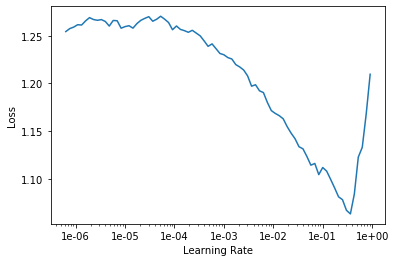

In [0]:
# freeze all layers before unfreezing gradually in the following step
learn_process.freeze()
learn_process.lr_find()
learn_process.recorder.plot()

In [0]:
# 3e-01/10
lr=3.0E-02
learn_process.fit_one_cycle(1,lr,moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,0.692450,0.602542,0.752027,00:05


In [0]:
# here we begin the gradual unfreezing strategy where we unfreeze layer by layer in a cumulative fashion
learn_process.freeze_to(-2)
lr/=2
# 2.6 was found be an optimal factor from experimentation (Howard and Ruder)
learn_process.fit_one_cycle(1, slice(lr/(2.6**4),lr),moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,0.662499,0.534211,0.791720,00:06


In [0]:
learn_process.freeze_to(-3)
lr/=2
learn_process.fit_one_cycle(1, slice(lr/(2.6**4),lr),moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,0.615240,0.490167,0.810926,00:09


In [0]:
#unfreeze all layers 
learn_process.unfreeze()

In [0]:
lr/=5
learn_process.fit_one_cycle(3, slice(lr/(2.6**4),lr), moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,0.530574,0.474604,0.819462,00:11
1,0.484834,0.473813,0.813487,00:11
2,0.400410,0.474223,0.813487,00:11


In [0]:
#an example of the model predicting a review 
learn_process.predict('quite a good experience, not perfect tho')

# end of model development

(Category negative, tensor(0), tensor([0.7257, 0.0660, 0.2084]))

### *Section 6. Results*

> With the prediction example, we have wrapped up our model development. We have come to the climax of our learning journey: results.
> The test accuracy is known to be the golden value that all models aim to break the record for.
> However, we will be going the extra mile here to understand the different aspects of performance of our model.
> We start by identifying the test accuracy. Followed by that, we will create a confusion matrix.


In [0]:
# test acc

vals=TextClassificationInterpretation.from_learner(learn_process)
test_acc=accuracy(vals.preds,vals.y_true)
print('Test acc is-',test_acc)



Test acc is- tensor(0.8135)


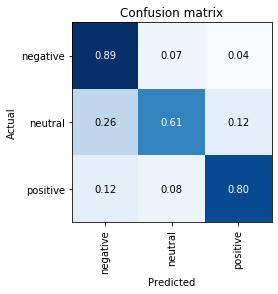

In [0]:
#confusion matrix, normalised to show accuracies for better understanding
vals.plot_confusion_matrix(normalize=True)

> The confusion matrix shows the overlap between the actual and predicted results. The values in each row should some up to 1.
> As shown above, we have achieved 89% accuracy on identifying negative reviews, 80% for positive and 61% for neutral.
> Thus our model needs to improve the most on identifying neutral tweets. It seems that the model is classifying a significant amount of neutral tweets, 28%, as negative tweets. 
> A reason for this could be the sentiment class imbalance identified in the beginning.

### *Section 7. Future Improvements*

> This model can be improved in the following 3 ways I have identified below:
>     1. The sentiment class imbalance problem can be solved by having the same number of examples for each sentiment. We can see if there is an improvement in the neutral class' accuracy.
>     2. Recently, Google published a paper on BERT which is a bidirectional transformer for language understanding. A key feature of BERT was that is works bidirectionally on the input sentences. In other words, it predicts both the preceeding and succeeding words. That way, the context can be captured in a much better way
>     3. Last but not least, we can try training 3 separate models:
>             *     positive and negative data
>             *     positive and neutral data
>             *     neutral and negative data
>         Then, we can create an ensemble of all the 3 models. That way, we may be able to achieve higher accuracies on each sentiment class and the model will be able to distinguish among the 3 classes to a greater extent


 

### *Section 8. Conclusion*

>  My aim for this notebook was to introduce the different aspects of developing the ULMFiT model for classifying airline tweets. I hope that beginners in deep learning and NLP will find this helpful and inspire them to improve this model by delving into more detail. I highly encourage readers to read more NLP papers such as BERT and XLNet which give both a good introduction to the capabilities of NLP and have a proper lead-in to the more advanced NLP concepts. A possible immediate step will be to try applying ULMFiT to another problem space such as Question Answering. I have listed the resources I have used to create this notebook in the following section. Please refer to them to delve deeper into ULMFiT.
> 

*Section 9. References*

> I have referred to the following resources and you may find them useful:
> 1. fast.ai documentation on their fasi.ai library:  https://docs.fast.ai/training.html
> 2. the ULMFiT babpe by Howard and Ruder et. al.: https://arxiv.org/pdf/1801.06146.pdf
> 3. A through analysis of the current state transfer learning of NLP by Ruder: https://ruder.io/state-of-transfer-learning-in-nlp/
> 4. A deep dive into 1cycle polcy by Gugger : https://sgugger.github.io/the-1cycle-policy.html
> 5. A notebook on using ULMFiT for Russian language modelling: https://github.com/mamamot/Russian-ULMFit
> 
> Thank you!


                                                                        THE END

 --> I have added an extension (Appendix A: Post Credits) to the notebook on Kaggle:
https://www.kaggle.com/ml00007/twitter-ulmfit/notebook?scriptVersionId=23284971

 I did not include it here as it was meant as it was meant to be an inspiration for readers of the Kaggle notebook to delve deeper into the possible improvements suggested